# Signal Processing

In this notebook we will explore methods for extracing signals from data.  This incldes computing correlation functions to tease out signals; convolution of data to model the impact of poin spread fuctions (beams in  and for use as a filter; the use of the fourier transform for filtering and for signal extraction.

### Correlation Functions
    
The correlation fuction is defined as
$$C(x)=⟨𝑓(𝑥′+𝑥)𝑔(𝑥′)⟩\tag{11}$$

which is actually the covariance from the previous notebook where $(x'+x) \rightarrow y$ and where the lag from $x'$ equals $x$.
 
Correlation functions are a way to measure the degree of similarity between a series and a lagged version of that same series, or even a another series. The former is an autocorrelation function, the latter is a cross-correlation.

<b> Warning: </b> for reasons I do not understand, many computational libraries conflate covariance and correlation. For instance, scipy.signal.correlate is equation 11. In order to meet the definition of correlation (at least [Pearson's definition of correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), which ranges from -1 to 1), one needs to be careful on what to provide as input to scipy.signal.correlate. See our example below.




  
Autocorrelation (also called serial correlation) is: 
- the correlation of a function with itself but with a varying lag. 
- can be calculated by the Pearson’s correlation coefficient. 
- uses the same series twice - once in it’s original form and once in it’s lagged form.




### Example

We will compute the correlations between two datasets. For example if <b>X</b> and <b>Y</b> are two arrays of data, the possible correlation coefficients which could be calcukated are $r_{XX}, r_{XY}, r_{YX}, r_{YY}$. Of course $r_{XX}$ and $r_{YY}$ are auto-correlations while $r_{XY}$ = $r_{YX}$ are cross-correlations.

We obtain tempoerature [data](https://www.wunderground.com) for a couple of months. We weill create arrays of daily temperatures which have a specified lag to them (i.e., one-day lag is x1=day 1-10; y1=day 2-11; two-day lag is y2=day 3-13....ten-day lag is x10=day 10-20; y10=day 20-30. We will apply numpy's "roll" function to make the task of creating lag vectors a bit easier. We can compare the results.

In [1]:
## read in the necessary libraries

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Get data arrays, and also generate random arrays with the same size and same variance.  The random arrays will be used as a refernce for the interpretation of the correlation of the data.

In [2]:
## set up arrays containing the data we will correlate

#Ann Arbor December 2021 temperature data from https://www.wunderground.com, first 29 days only
dec_avg = np.array([37.0,46.1,34.9,36.6,37.4,36.9,23.1,27.8,32.1,44.4,46.2,37.7,39.3,38.8,49.1,54.5,36.4,33.2,29.7,33.5,32.0,26.8,32.4,43.0,46.5,33.9,35.7,33.2,33.6])
aug_avg = np.array([68.1,67.9,70.7,71.9,73.5,74.8,74.7,77.5,76.0,79.4,76.1,74.0,77.0,70.1,68.4,67.8,70.8,74.9,76.7,77.6,76.8,80.4,77.3,78.4,78.3,81.3,78.3,80.9,79.3])
#The day of the month 
day = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])


## for reference, we will also create two random arrays so we can test if the signals we see are statistically signifcant
#Let's define a purely random series of tempersatures that has the same mean and spread of the data.
random1_avg = np.random.normal(np.mean(dec_avg), np.std(dec_avg), size = len(dec_avg))
random2_avg = np.random.normal(np.mean(aug_avg), np.std(aug_avg), size = len(aug_avg))



In [3]:
## A home grown correlation function

def Homegrown_correlation(data,end,roll):
    ## make arrays store the lags consisdered and an array of the correlations-- before averaging 
    lag = np.arange(0,end,1)
    temp = np.zeros((end,end))  ## 2d array conaining all the prodcts between data and itself with lags
    for j in range(end):
        for i in range (end):
            if (roll):  ## compute the data times its lagged self, using on np.roll
                avg_day = data
                avg_lag = np.roll(data,i)      
            else:      ## compute the data times its lagged self, using on array indexing-- this is the same as roll
                avg_day = data[j:j+end]
                avg_lag = data[j+i:j+i+end]
            ## store the correlation coeffcient
            temp[j,i] = np.corrcoef(avg_day,avg_lag)[1,0]
            # or we could use r_xy = (np.mean((avg_day - np.mean(avg_day))*(avg_lag - np.mean(avg_lag))))/(np.sqrt(np.var(avg_day)*np.var(avg_lag)))    
    correlation = np.mean(temp,axis=0)  ## do the averaging
    return(lag,correlation)

## some setup variables-- the fuciton has two options, rol 

#Define max lag time (be careful with edges, maybe don't go beyond vector length*3) 

#We have two choices, NUMPYs "roll" or our own defined lag.
#Keep in mind that our max lag is 9 days (min lag is 0 days) unless we "roll over" the data
roll = True
if (roll):
    end = 29
else:
    end = 10
    
    

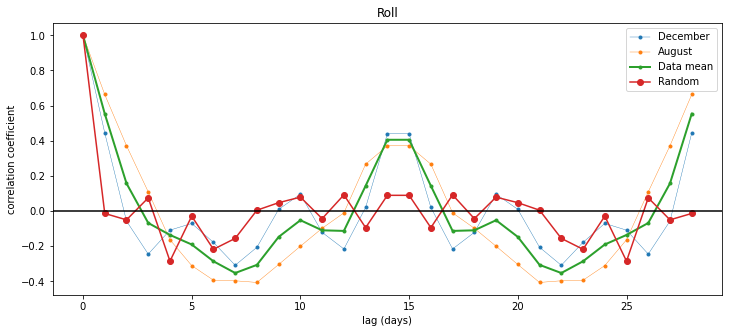

In [4]:
## compute the correlations 
lag,dec_corr = Homegrown_correlation(dec_avg,end,roll)
lag,aug_corr = Homegrown_correlation(aug_avg,end,roll)
lag,random1_corr = Homegrown_correlation(random1_avg,end,roll)
lag,random2_corr = Homegrown_correlation(random2_avg,end,roll)


## average the data correlations and the random correlations together.
data_corr_avg = (dec_corr + aug_corr)/2
random_corr_avg= (random1_corr + random2_corr)/2.0


#############################

## now make a plot
#Now, make the plot
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,1,1)  

ax1.plot(lag,dec_corr,'.-',linewidth=0.4, label='December')
ax1.plot(lag,aug_corr ,'.-',linewidth=0.4,label='August')
ax1.plot(lag,data_corr_avg ,'.-',linewidth=2,label='Data mean')

ax1.plot(lag,random_corr_avg,'o-',label='Random')
ax1.axhline(0,color='black')
ax1.set_xlabel('lag (days)')
ax1.set_ylabel('correlation coefficient')
ax1.legend()
if (roll):
    ax1.set_title('Roll')
else:
    ax1.set_title('Lag vectors')
plt.show()



### discuss: 
    What's happening at t=14 or t =15 days or t=30 days?
    

## alternative implementation

We will use scipy.signal library and the correlate function. We also need the lags given by correlation_lags (instead of calculating our own). <b> The function signal.correlation_lags is only available in scipy 1.6+</b>

<b>NOTE:</b> scipy.signal.correlate does not naturally return the equivalent of the Pearson correlation (see above). In order to do so, one must use the centered data and also normalize the input to the standard deviation.


1.7.1


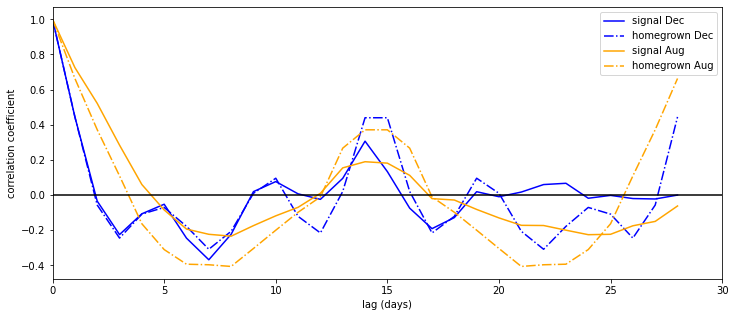

In [5]:
##You must have version scipy.signal >=1.7 to use correlation_lags
import scipy
print(scipy.__version__)
import scipy.signal as signal

dec_corr2 = signal.correlate((dec_avg - np.mean(dec_avg))/np.std(dec_avg),(dec_avg - np.mean(dec_avg))/np.std(dec_avg),mode='full',method='direct')/len(dec_avg)
dec_lag2 = signal.correlation_lags(dec_avg.size,dec_avg.size,mode='full')
aug_corr2 = signal.correlate((aug_avg - np.mean(aug_avg))/np.std(aug_avg),(aug_avg - np.mean(aug_avg))/np.std(aug_avg),mode='full',method='direct')/len(aug_avg)
aug_lag2 = signal.correlation_lags(aug_avg.size,aug_avg.size,mode='full')

#Now make the plot
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,1,1)  
ax1.plot(dec_lag2,dec_corr2,'b',label='signal Dec')
ax1.plot(lag,dec_corr,'b',linestyle='-.',label='homegrown Dec') 
ax1.plot(aug_lag2,aug_corr2,'orange',label='signal Aug')
ax1.plot(lag,aug_corr,'orange',linestyle='-.',label='homegrown Aug') 
ax1.axhline(0,color='black')
ax1.set_xlabel('lag (days)')
ax1.set_ylabel('correlation coefficient')
ax1.set_xlim(0,30)#NOTE THE LIMIT OF 0. What happens if I DROP THIS?
ax1.legend()
plt.show()

Note that both calculates are close to each other, but not identical. When in doubt and when you want a correlation coefficient (function), use np.corrcoef.

While it does make things less cumbersome, you still need to be careful about your interpretation of the resultes.

For instance, I plotted only for lags >0. If you remove that, you will see the mirror image appear:

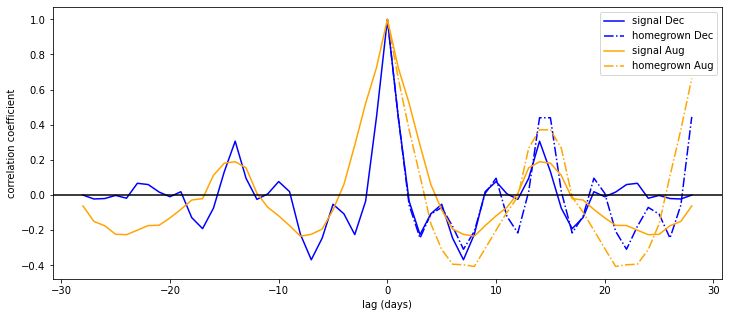

In [6]:
#Now make the plot
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,1,1)  
ax1.plot(dec_lag2,dec_corr2,'b',label='signal Dec')
ax1.plot(lag,dec_corr,'b',linestyle='-.',label='homegrown Dec') 
ax1.plot(aug_lag2,aug_corr2,'orange',label='signal Aug')
ax1.plot(lag,aug_corr,'orange',linestyle='-.',label='homegrown Aug') 
ax1.axhline(0,color='black')
ax1.set_xlabel('lag (days)')
ax1.set_ylabel('correlation coefficient')
ax1.legend()
plt.show()

####  Some lessons
    - Covariance and correlation are often confusing conflated in the literature
    - for instance, if the data have unit variance (i.e. a scaled Gaussian), correlation is exactly covariance
    - sometimes texts/authors will assume the variance can just be scaled out and write their theory accordingly
    - you don't always know that or understand the consequences of a throw-away comment in their text
    - Calculating covariance is straightforward, but occasionally there can be numerical issues (see Wikipedia for examples)
    - There is no "right" way to calculate correlation (see above where we tried 3(!) techniques) and they do not always agree. 
    - The 2-pt spatial correlation function is calculated through "pair counting" within spheres of radius $R$ --the lag. Counts are made in the data and compared to randomly distributed points. This looks NOTHING like the tools we have used above which are common in 1D signal processing.
    - The coin example is another case where we have "made up" our measure of correlaton.
 
   
#### Final thought on Correlation
    
When discussing signal processing, you will often see correlation expressed as a continuous integral:

$$(f \otimes g)(\tau) = \int_{-\infty}^\infty f^*(t) g(t + \tau) dt  \tag{12}$$

where $f$ and $g$ are signals at given times $t$ with some lag $\tau$. If the signal is light (or anything that could be represented as a complex number), then we require the complex conjugate of $f$ in the integrand (shown as $f^*$.



## 3. Convolution

Imagine you manage a hospital treating patients with a single disease. 

You have:

- A treatment plan: [3] Every patient gets 5 units of the cure on their first day.
- A list of patient counts per day of the week: [1 2 3 4 5]

How much medicine do you use each day? 

5 $\times$  [ 1 2 3 4 5] = [5 10 15 20 25] units....easy.

You change to a more realistic treatment plan: 
- A treatment plan: [5 3 1] Every patient gets 5 units of the cure on their first day, 3 their second, 1 their third.

We can do this, but it gets harder. 

The trick is to flip the treatment plan to [1 3 5]  and walk the treatment schedule backwards through the patients. Here's the view:

Monday

    1  3  5                  
          *
         [1  2  3  4  5] 
    
         =5           
            
Tuesday

      1  3  5       
         *  *
        [1  2  3  4  5]
    
         3 +10 = 13
              

Wednesday
 
          1  3  5 
          *  *  *
         [1  2  3  4  5]
    
          1 + 6 + 15 = 22
             
Thursday

             1  3  5
             *  *  *
         [1  2  3  4  5]
    
             2+ 9 +20 = 31
        
Friday

                1  3  5
                *  *  *
         [1  2  3  4  5]
       
                3 +12+25 = 40            

And we have to finish the treatments of the patients who came in later in the week:

Saturday

                   1  3  5
                   *  *
         [1  2  3  4  5]
    
                   4 + 15 = 19
      
Sunday

                      1  3  5
                      *
         [1  2  3  4  5]
    
                      = 5

Which leaves us with the following requirements for our treatment units:
[5 13 22 31 40 19 5]

This calculation is the convolution of the plan and patient counrs.


### the definition
When discussing signal processing, you will often see convolution expressed as:

$$(f \star g)(\tau) = \int_{-\infty}^\infty f(t) g(\tau -t) dt \tag{13}$$
$$(g \star f)(\tau) = \int_{-\infty}^\infty f(\tau -t) g(t) dt$$

Note the new symbol $\star$ representing the operation and note that one of functions is <i> reversed </i>. We speak of $f$ being the source and $g$ being the filter of the convolution.


### properties 
Some useful properties of the convolution include:

- It is commutative
- It integrates as seperable functions: $$\int f \star g = \int f \int g$$
- $\displaystyle{f(t) * \delta(t) = f(t)}$
- $\displaystyle{f(t) * \delta(t - T) = f(t - T)}$


### example

The <a href="https://en.wikipedia.org/wiki/Convolution">convolution</a> of two discretely sampled (with $N$ samples) functions $f_i$ and $g_i$ is defined as $$(f * g)_k = \sum_{i=0}^{N-1} f_k g_{i-k} \tag{12}$$.

In other words, to calcuate the convolution: (1) multiply two functions and sum them to get a number and (2) repeat the procedure for all possible offsets.

We next compute the convolution of a gaussian or $\chi^2$ with two delta functions using equation 12:

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def convolution(f,g):
    g=g[::-1]
    N = np.size(f)
    conv = np.zeros(N)
    i = 0
    while (i <N):
        conv[i] = np.sum(f *np.roll(g,i))
        i+=1
    return(conv)


In [9]:
#Import a chi2 library from stats
from scipy.stats import chi2
N = 512
t = np.arange(1,N+1)/N ## n/N becomes time, a variable from 0 to 1. Note that it is COMPLEX


#Create the two delta functions over the 1024 space used earlier.
f = np.zeros(N)
f[int(N*1/6)] = 1.
f[int(N*5/6)] = 1.


## create a function to convolve with our delta funcitons.
gauss=True

if chi2:    
    g = chi2.pdf(np.real(t), 55)
    g = g/np.max(g)
if gauss:
    g = np.exp(-5 * ((t-np.mean(t))/.1)**2.)

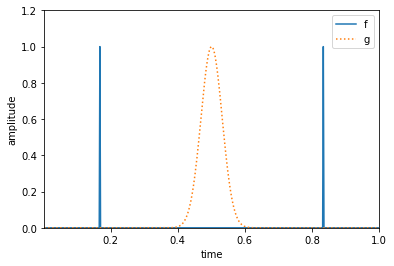

In [10]:
#run the convolution
conv = convolution(f,g)
#plot the results
plt.plot(t,f, label='f')
plt.plot(t,g, ':', label='g')
#plt.plot(t,conv,"r", label='convolution')
plt.legend(loc='best')
plt.axis([np.min(t),np.max(t),0,1.2])

plt.xlabel("time")
plt.ylabel("amplitude")
#pl.title("f (blue), g(green), and the convolution of these (red)")
plt.show()

Notice that the convolved delta functions are not at the correct location. This is because the lag ($\tau$ in the formula or $i$ in the code) walks forward from where it starts (see above example). So our lags have a <i> shift </i> that we must account for, which in this case is N/2 What's tne solution? We <i>roll</i> $t$ forward by this amount:

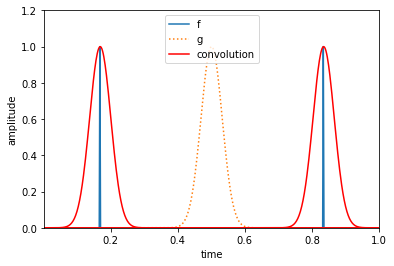

In [11]:
#run the convolution
conv = convolution(f,g)
#plot the results
plt.plot(t,f, label='f')
plt.plot(t,g, ':', label='g')
plt.plot(np.roll(t,int(N/2)),conv,"r", label='convolution')
plt.legend(loc='best')
plt.axis([np.min(t),np.max(t),0,1.2])

plt.xlabel("time")
plt.ylabel("amplitude")
#pl.title("f (blue), g(green), and the convolution of these (red)")
plt.show()

We can also just remove this shift if we change our "filter" ($g(t)$) to be centered on the origin. In many cases, it is best to just keep things centered at the origin if possible, especially the filter inside a convolution.

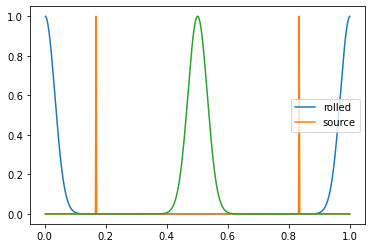

In [12]:
plt.plot(t,(np.roll(g,int(N/2))),label='rolled')
plt.plot(t,f, label='source')
plt.legend()
plt.plot(t,g)

In [13]:
# Roll the function g by the Nyquist frequency to shift it
conv_shift = convolution(f,np.roll(g,int(N/2)))

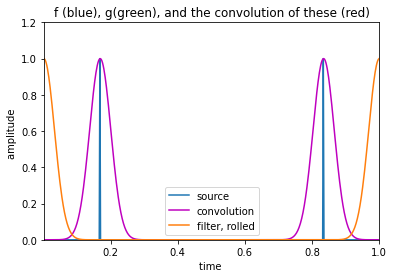

In [14]:
#plot it
plt.plot(t,f, label='source')
plt.plot(t,conv_shift,"m", label='convolution')
plt.plot(t,np.roll(g,int(N/2)),label='filter, rolled')
plt.legend(loc='best')
plt.axis([np.min(t),np.max(t),0,1.2])

plt.xlabel("time ")
plt.ylabel("amplitude ")
plt.title("f (blue), g(green), and the convolution of these (red)")
plt.show()

## 4. Fourier series 

- The Fourier Series is the circle & wave-equivalent for estimating a function like one does with a [Taylor Series](https://en.wikipedia.org/wiki/Taylor_series). 

- The Fourier Series breaks down any periodic function into a simple series of sine & cosine waves.

- The Fourier Series a key underpinning to any & all digital signal processing

- a Fourier Series cannot be applied to general functions — it can only converge to periodic functions

### Example
We want to approximate a periodic function f(x), with fundamental period T, with a Fourier series. 

Suppose our function $f(x)$ looks like this (note that we will carefully and explicitly make it periodic):

512


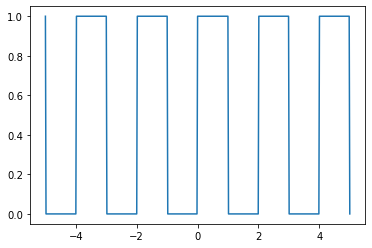

In [15]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

x = np.linspace(0,5,257)
y = []
for i in range(len(x)):
    y = np.append(y, np.piecewise(x[i], [(int(x[i])%2) != 0 < 0, (int(x[i])%2) == 0], [-1, 1]))
x2 = np.linspace(-5,0,256)
y2 = []
for i in range(len(x2)):
    y2 = np.append(y2, np.piecewise(x2[i], [(int(x2[i])%2) == 0 < 0, (int(x2[i])%2) != 0], [-1, 1]))
xvec = np.append(x2[0:len(x2)-1],x) #We stop x2 JUST BEFORE it hits zero, since x starts with zero.
yvec = np.append(y2[0:len(y2)-1],y)
plt.plot(xvec,yvec)
print(len(xvec))
fx = yvec

$$g(x) = \displaystyle\sum_{n=0}^{?} \{a_n cos(n\times x) + b_n sin(n\times x)\} \tag{16}$$

where $g(x)$ is the approximation of the function $f(x)$. 

Summing a series to $\infty$ is problematic. Limits can sometimes be applied, but computers do not work to $\infty$.

Notice that we can re-write equation (16) as:

$g(x) = {a_0} + \displaystyle\sum_{n=1}^{?} \{a_n cos(n\times x) + b_n sin(n\times x)\}$  

Notice that $g(x)$ is a constant and a series of sines and cosines, with $b_0 =0$.

###### Periodicity implies constraints on what $n\times x$ can be. How do we rewrite eq 1 to reflect this?


$g(x) = a_0 + \displaystyle\sum_{n=1}^{?} \{a_n cos(\frac{2\pi n}{P}\times x) + b_n sin(\frac{2\pi n}{P}\times x)\}$

where $P$ here is the period of the repeatibility of the function. 

###### When does the series stop?

$$g_{M,N}(x) = {a_0} + \displaystyle\sum_{m=1}^{M} a_m cos(\frac{2\pi m}{P}\times x) + \displaystyle\sum_{n=1}^{N} b_n sin(\frac{2\pi n}{P}\times x) \tag{17}$$


for now, we stop at M and N, but we need to decide this later.....

##### What do the terms means and how do we solve for them?

The first term in equation 17 is just the average value of $f(x)$. The series is then constructed to provide the right amount (and sign) of variations around this average to $f(x)$.

So we just use equation 3 (the arithmetic mean) to explain $a_0$:

$$
a_0 = \frac{1}{P}\displaystyle\int_{0}^{P} f(t) dt 
$$

So what is $a_0$ for our function which has a period $P=2$?


### working our example:
So let's write down that the solutions to all of our (many) variables can be written as:

$$
\begin{align}
a_0 & = \frac{1}{P}\displaystyle\int_{0}^{P} f(t) dt \tag{18}\\
a_m & = \frac{2}{T}\displaystyle\int_{0}^{P} f(x) cos(\frac{2\pi m x}{P}) dx \ \ \ \ \rm{for\ m = 1,2,3...\infty} \tag{19}\\
b_n & = \frac{2}{T}\displaystyle\int_{0}^{P} f(x) sin(\frac{2\pi n x}{P}) dx \ \ \ \ \rm{for\ n = 1,2,3...\infty} \tag{20}\\
\end{align}
$$


It turns out that ALL of the a_m $(>0)$ are exactly zero. This is because after adjusting for the offset $a_0$, $g(x)$ becomes an <i>odd function</i>, while cosines are necessarily <i>even functions</i> and that none of the cosine terms could contribute to $g(x)$. The same is true for the $b_n$ when $n$ is even.

We can solve the equation for this simple piecewise function ($f(x)$) to be $\frac{2}{n\pi}$ for any $n$. 
So let's add in the $b_3$ term =  $\frac{2}{3\pi}$:  
$g_{\rm 3\ terms}(x) = 0.5\ + \frac{2}{\pi}sin(\frac{2\pi x}{2}) + \frac{2}{3 \pi}sin(\frac{2 \pi 3 x}{2}) + ... + \frac{2}{n \pi}sin(\frac{2 \pi n x}{2})$


(-1.0, 2.0)

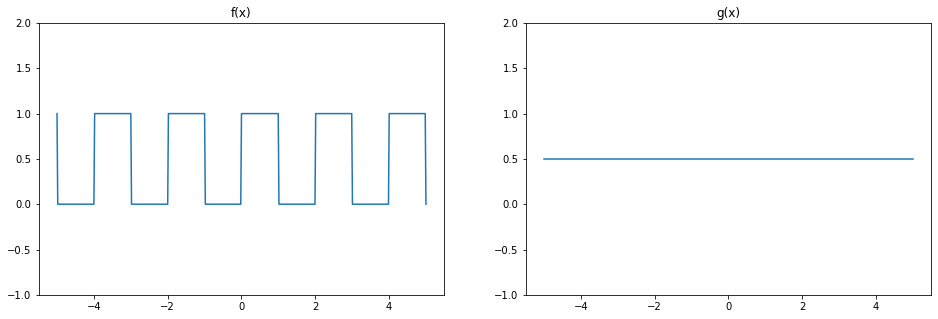

In [16]:
N = 0
#Pick your N to sum the series to
gx_full = np.ones(np.size(fx)) *.5  ## te constant or a_0 term

for i in range(1,N,2):  # add in the next N terms for b_n, note the odd terms arn't present so we count by2
    gx_full = gx_full + 2/(np.pi*i)*np.sin(2*i*np.pi*xvec/2) 
    
    
#Now, make the plot
fig = plt.figure(figsize=(16,5))
ax1 = plt.subplot(1,2,1)  
ax2 = plt.subplot(1,2,2) 

ax1.plot(xvec,fx)
ax1.set_title('f(x)')
ax1.set_ylim(-1,2)
ax2.plot(xvec,gx_full)
ax2.set_title('g(x)')
ax2.set_ylim(-1,2)

### Excercise  
make plots of n=0 (is there a non-zero contribution to this term), n = 2, n=4, n=10, n=50, n=200.  note the convergance between n = 2 and n = 10.  Do you see the "Gibbs phenomina" at n = 50?  what about n = 200?

comment here on the excercise

## Fourier Transforms

As we discuss above, a Fourier series can represent most periodic functions as a sum of sinusoids. Each sinusoid in the series is defined so that the number of cycles in the period of the function it represents is an integer. If you have a reasonable (and periodic) function like the two examples above, this will work great. 



If the function is not periodic, you can think of it as being “periodic” with infinite period. The <i>Fourier transform</i> is an analog of the Fourier series for “periodic” functions with infinite period.

You can derive the Fourier transform in a way consistent with that intuition. You write out the Fourier series for an interval of a certain length, where that length is the period of the functions the series can represent. You assume that length goes to infinity, i.e., the period of the representable functions becomes infinite and show that this converges to the Fourier transform.


If we re-do some of the math for equation 17 except over the interval $[0, 2\pi]$, we get:
$$f(t) = \frac{a_0}{2\pi} + \frac{1}{\pi}\displaystyle\sum_{m} a_m cos(m t) + \frac{1}{\pi}\displaystyle\sum_{n} b_n sin(n t) $$

Let's replace $a_m$ with $F$ and $b_m$ with $F'$. Also, let's back out the constant, which means we need to do the sum from $m=0$ and $n=0$ and we can stop at $\infty$:

$$f(t) =  \frac{1}{\pi}\displaystyle\int_{m=0}^{\infty} F_m cos(m t) dt + \frac{1}{\pi}\displaystyle\int_{m=0}^{\infty} F_m' sin(m t) dt \tag{21} $$

In the above equation 21, we have just "unsimplified" things and put everything into integral form. In this representation, the Fourier Coefficients are:

$$F_m = \int f(t) cos(mt) dt\ \ \ \rm{and} \ \  \ F_m' = \int f(t) sin(mt) dt$$,

which should look familiar against equations 19 and 20.

Let's now define the following $F(m) = F_m - i F_m' $, change the integral from $-\infty$ to $\infty$, and change $m$ to be represented by $\omega = 2\pi/T = 2\pi f$. <i> We are transforming from sines and cosines to the unit circle.</i>  We arrive at the definition of the <i>Fourier transform</i>:

$$F(\omega) = \displaystyle\int_{-\infty}^{\infty} f(t) e^{-i\omega t}dt \tag{22}$$

We say that $f(t)$ lives in the time domain, and $F(\omega)$ lives in the frequency domain. $F(\omega)$ is just another way of looking at the corefficients of a series of waves (i.e., it is a function of frequency) which when combined correctly, recreates the function in the time domain, $f(t)$.

Don't get overwhelmed by this definition. In fact, sources tell me that Joseph Fourier originally did not use the Euler's formula (and therefore did not use imaginary numbers). He modified his original version using sines and cosines after realizing the elegance of the math (specifically the properties of the differential of an exponential).

To get the original function back, we use the <i> inverse Fourier transform</i>:

$$f(t) = \frac{1}{2\pi}\displaystyle\int_{-\infty}^{\infty} F(\omega) e^{i\omega t}dt \tag{23}$$

Note carefully the similarities and differences between the forward (eq 22) and inverse (eq 23) transforms. Hopefully, these look easier than what we were doing with sines and cosines prior.

Unlike the Fourier series to represent a periodic function, the Fourier transform can represent any function. 

If there <i>is</i> periodicity, it shows up in the amplitudes of the coefficients, with some frequencies being preferred over other frequencies.

As we mentioned above with the Fourier series, eou can think of Fourier transform as calculating correlation between $f(t)$ and a complex exponential of each frequency $\omega$, comparing how similar they are. Complex exponentials like that have the nice quality that they can be time-shifted by multiplying them with a complex number of unit magnitude (a constant complex exponential). If the Fourier transform result at a particular frequency is a non-real complex number, then the complex exponential of that frequency can be multiplied by that complex number to get it shifted in time so that the correlation to $f(t)$ is maximized.


###  The Discrete Fourier Transform

In nearly all realistic cases (i.e., non trivial), to apply a Fourier Transform one must use  a <a href="https://en.wikipedia.org/wiki/Discrete_Fourier_transform">discrete Fourier transform</a>:

$$X_k = \sum_{n=0}^{N-1} x_n e^{-2\pi i k n / N}$$

In the above formulism, $X$ and $x$ are both series of complex numbers. $X_k$ describe the amplitudes of a series of sines and cosines in terms of frequency. The $x_n$ do the same, except in terms of time. Of course you can conduct a Fourier transform in spatial data, where we use $X_k$ to describe the amplitudes of frequency coefficients (i.e., in terms of <i>wavenumber</i>) and $x_x$ to describe the spatial coefficients.

As with with every Fourier transform routine, make sure to check the normalization and sign conventions. Note that numpy has its own version that we will also use.



In [17]:
def fourier(x):
    N = len(x)
    fourier = np.zeros(N,dtype=complex)
    for k in range(N):
        fouriern=0
        for n in range(N):
            fouriern += x[n]*cm.exp(-1j*pi2*k*n/N)
        fourier[k]=fouriern
    return fourier


The inverse Fourier transform is defined as:

$$x_n = \frac 1 N \sum_{n=0}^{N-1} X_k e^{2\pi i k n / N}$$

Each ${\displaystyle X_{k}}$ is a complex number that encodes both amplitude and phase of a complex sinusoidal component ${\displaystyle (e^{i2\pi kn/N})}$ of function ${\displaystyle x_{n}.}$ The sinusoid's frequency is k cycles per N samples.

In [18]:
def inv_fourier(X):
    N = len(X)
    inv_fourier = np.zeros(N, dtype=complex)
    for n in range(N):
        inv_fourierk=0
        for k in range(N):
            inv_fourierk += X[k]*cm.exp(1j*pi2*n*k/N)
        inv_fourier[n] = inv_fourierk/N
    return inv_fourier

Using these definitions of the fourier transform and inverse fourier transform we can now work a simple example.  We will input sine waves with differeing phases and undersand how phase interacts with the complex numbers in our serires.

In [19]:
import matplotlib   # plotting libraries  
import matplotlib.pyplot as plt   # plotting libraries  
import cmath as cm  # complex math
import numpy as np  # numerical routines 
%matplotlib inline  
#Whenever we take the absolute value of the FFT, we will get warnings about losing the imaginary part. Sooo
import warnings
warnings.filterwarnings('ignore')
pi2 = cm.pi * 2.0   # a useful constant: 2 * pi

In [20]:
#What do we need to define?
N = 512*1 # degrees (Number of samples)
a = 50 #float(np.random.randint(1, 100))  ## random integer (amplitude) between 0 and 100
k = 5. #float(np.random.randint(1, 50))  ## random integer (frequency) between 0 and 50
p1 = 0 #float(np.random.randint(0, 360))  ## random integer (phase) between 0 and 360
p2 = 180 #float(np.random.randint(0, 360))  ## random integer (phase) between 0 and 360

Input Sine Wave Paramaters:
frequency = 5.0
amplitude = 50
phase angs = 0 180


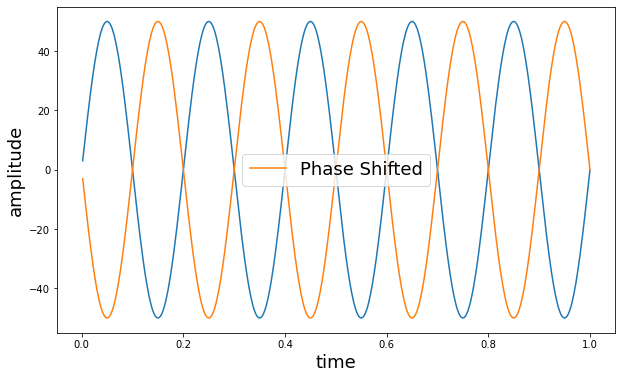

In [21]:
## print out the sine wave paramaters 
print("Input Sine Wave Paramaters:")
print("frequency = " + str(k))   ## not that strings can be added in python, very convenient
print("amplitude = " + str(a))
print("phase angs = " + str(p1), str(p2))

## make a pure sine wave array
t = np.arange(1,N+1, dtype=complex)/N   ## n/N becomes time, a variable from 0 to 1. Note that it is COMPLEX
fn1 = a * np.sin(pi2* k * t + p1 / 360. * pi2)   ## the pure sine wave 
fn2 = a * np.sin(pi2* k * t + p2 / 360. * pi2)   ## the pure sine wave shifted in phase
plt.figure(figsize=(10, 6))  ## this resizes the figure to make it fit the screen
plt.plot(t,fn1.real)
plt.plot(t,fn2.real, label='Phase Shifted')
plt.xlabel("time",size=18)
plt.ylabel("amplitude",size=18)
plt.legend(fontsize=18)
plt.show()

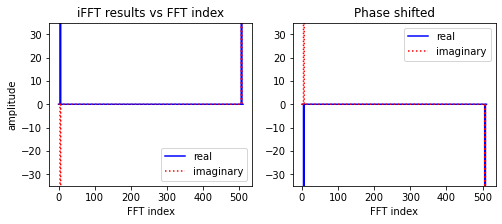

In [22]:
#Now, use the inverse FFT, since it gets us the frequency amplitudes
fouriertrans1 = fourier(fn1)  ## fourier transfomr using our code
fouriertrans2 = fourier(fn2)  ## fourier transfomr using our code

#plot it up
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
ax[0].set_xlabel("FFT index")
ax[0].set_ylabel("amplitude")
ax[0].set_title("iFFT results vs FFT index")
ax[0].plot((fouriertrans1.real),'b',label='real')
ax[0].plot((fouriertrans1.imag),'r:',label='imaginary')
ax[0].legend()
ax[0].set_ylim(-35,35)
ax[1].set_title("Phase shifted")
ax[1].plot((fouriertrans2.real),'b',label='real')
ax[1].plot((fouriertrans2.imag),'r:',label='imaginary')
ax[1].set_xlabel("FFT index")
ax[1].legend()
ax[1].set_ylim(-35,35)
plt.show()

The output of the FFT includes both positive and negative frequency components. You can think of the positive and negative components as right and left going waves.
  
The ${\rm {\bf amplitude}}$ of the waves is given by the quadrature sum of the real and imaginary parts (e.g., the magnitude of the complex FFT).

The FFT index (the x axis) is not easily informative. Note that the transform itself <i>never</i> asked for or used the frequency. It only responds to the index of the data.

### frequency

Next we create an a frequency array in the same indexing scheme of the FFT.  We do this by identifiying the highest frequnecy that can be encoded within our array (the [Nyqyist-Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)).  This is called the Nyquist frequency and is calculated as $f_{Nyquist} = 1/T_{sample}/2$, where $T_{sample}$ is the time between samples. We will come back to this in a little bit.

The FFT can be thought of as producing a set vectors each with an amplitude and phase. We want to change the reference point for a phase angle of zero, from the edge of the FFT aperture, to the center of the original input data vector.

The phase (and thus the real component of the complex vector) of the result is sometimes less "jumpy" when this is done, especially if some input function is windowed such that it is discontinuous around the edges of the FFT aperture. Or if the input is symmetric around the center of the FFT aperture, the phase of the FFT result will always be zero after an fft_shift.

We next make the frequency array and compare it to the FFT index:

Nyquist frequency:  256.0
0.5009784735811991
[ 0.50097847  1.50293542  2.50489237  3.50684932  4.50880626  5.51076321
  6.51272016  7.5146771   8.51663405  9.518591   10.52054795 11.52250489
 12.52446184 13.52641879 14.52837573 15.53033268 16.53228963 17.53424658
 18.53620352 19.53816047]


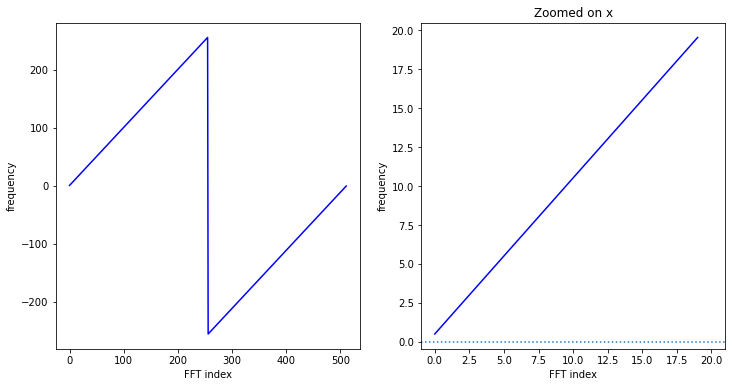

In [23]:
## make an array to represent the frequency
index = np.arange(0,N,1)
delta_t = (t[1]-t[0]).real  ## the step size for the t grid
freq_nyquist = 1/delta_t/2.
print("Nyquist frequency: ", freq_nyquist)

# we are going to "roll" (see above) the frequencies around by N/2 to center everything on zero. This is convention.
freq = np.roll(np.linspace(-1,1,N)*freq_nyquist,int(N/2.0)) #Elements that roll beyond the last position are re-introduced at the first.


## plot the freuency array
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].set_xlabel("FFT index")
ax[0].set_ylabel("frequency")
ax[0].plot(index,freq,'b', label='freq')
print(freq[0])
ax[1].set_xlabel("FFT index")
ax[1].set_ylabel("frequency")
xmin = np.int(N/2-3)
xmax = np.int(N/2+3)
xmin=0
xmax=20
print(freq[xmin:xmax],)
ax[1].plot(index[xmin:xmax],freq[xmin:xmax],'-b', label='freq')
ax[1].axvline(512,ls=':')
ax[1].axhline(0,ls=':')
ax[1].set_xlim(xmin-1,xmax+1)
ax[1].set_title('Zoomed on x')
plt.show()

How do we interpret these plots?

On the left, we see that the index maps the frequency from 0 to the Nyquist frequency at N/2, and. It then then rolls around to the negative frequencies through to zero.

The zero frequency is almost at the zero index, but off by 1/2, so my roll is not perfect. 

Now that we have the frequency array we can plot the FFT vs frequency and easily interpret the results.

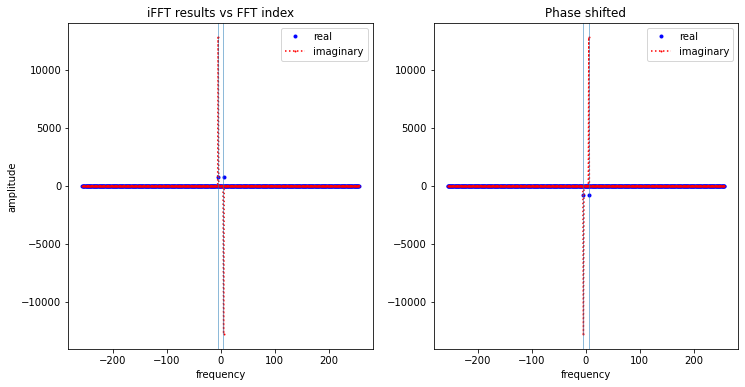

In [24]:
## make a plot of the real and imaginary parts of the FFT vs frequency
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].set_xlabel("frequency")
ax[0].set_ylabel("amplitude")
ax[0].set_title("iFFT results vs FFT index")
ax[0].plot(freq,(fouriertrans1.real),'.b',label='real')
ax[0].plot(freq,(fouriertrans1.imag),'.r:',ms=2,label='imaginary')
ax[0].axvline(k,ls='-',lw=0.5)
ax[0].axvline(-k,ls='-',lw=0.5)
ax[0].legend()
ax[1].set_title("Phase shifted")
ax[1].plot(freq,(fouriertrans2.real),'.b',label='real')
ax[1].plot(freq,(fouriertrans2.imag),'.r:',ms=2,label='imaginary')
ax[1].set_xlabel("frequency")
ax[1].axvline(k,ls='-',lw=0.5)
ax[1].axvline(-k,ls='-',lw=0.5)
ax[1].legend()
plt.show()

This is a much more intrepretable results than the previous view (i.e., against the index). Note how the roll brings the peaks to the center = 0. NOTE-- this is the exact same data as the pervious plot, but now with the frequenxy as the X-axis rather than the array index.



So what's with the negative frequencies?

Negative frequency doesn't make much sense for sinusoids, but the Fourier transform doesn't break up a signal into sinusoids, it breaks it up into complex exponentials. These are actually spirals, spinning around in the complex plane:

<img src="https://www.researchgate.net/profile/Richard-Lyons-2/publication/261779218/figure/fig2/AS:338162934140930@1457635734973/The-value-of-the-e-j2pf-o-t-complex-exponential-signal.png"></img>
<br>

Spirals can be rotating clockwise or counterclockwise, thus the concept of negative frequency. Alternatively, you can also think of it as the phase angle going forward or backward in time.

In the case of <i>real</i> signals, there are always two equal-amplitude complex exponentials, rotating in opposite directions, so that their real parts combine and imaginary parts cancel out, leaving only a real sinusoid as the result. 

<i>This is why the spectrum of a sine wave always has 2 peaks, one positive frequency and one negative</i>. Depending on the phase of the two spirals, they could cancel out, leaving a purely real sine wave, or a real cosine wave, or a purely imaginary sine wave, etc.

The negative and positive frequency components are both necessary to produce the real signal, but if you already know that it's a real signal, the other side of the spectrum doesn't provide any extra information, so it's often ignored.

###  Interesting Properties


The following properties of the Fourier transform become essential when interpreting the frequency components of time-domain measurements.

-  The Fourier transform of a convolution is the point-wise product of the individual Fourier transforms:
$$F(f \star g) = F(f) · F (g)$$
where here, $F$ denotes the transform.
-the Fourier transform of a product is a convolution of the two transforms:
$$F(f · g) = F(f) \star F (g)$$



### Example Filtering a Signal

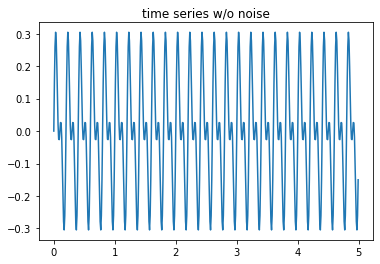

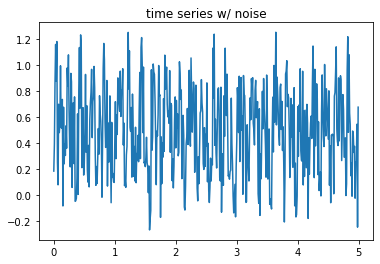

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import *

# make up a noisy signal
dt=0.01
t= np.arange(0,5,dt) #vector of times for the signal
f1,f2= 5, 10  #frequencies of 2 sine waves
n=t.size
s0=  0.2*np.sin(2*np.pi*f1*t)+ 0.15 * np.sin(2*np.pi*f2*t) #combine the series into the signal
plt.plot(t,s0)
plt.title('time series w/o noise')
plt.show()

#Add noise. We will want to remove this later
sr= np.random.rand(np.size(t)) 
s=s0+sr
plt.plot(t,s)
plt.title('time series w/ noise')
plt.show()

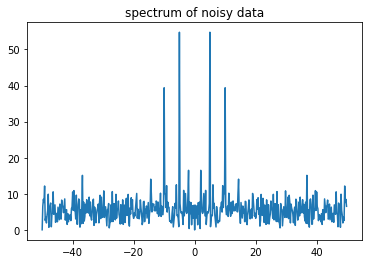

In [26]:
#Move the noisy signal to frequency space via the FFT
fn4 = s
fn4-= s.mean()  # best to always take relative to the mean
freq_fn4=fft.fftfreq(n,dt)  # see above 
fn4_freq = freq_fn4
fft_fn4=fft.fft(fn4) 
plt.plot(fft.fftshift(freq_fn4),fft.fftshift(np.abs(fft_fn4) )  )
plt.title('spectrum of noisy data')
plt.show()

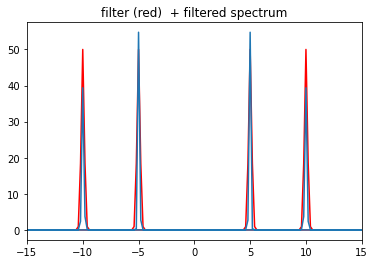

In [40]:
#create a narrow bandpass filter FUNCTION (i.e., vs. the frequency of the signal) using a Gaussian. 
#The width of the gaussian (sigma) is 0.1
#Note that the gaussian filters are made already IN FREQUENCY space. We use the proprties of the convolution 
#and the FFT to created the filtered signal in fourier space.
df=0.1
gauss_p= np.exp(- ((fn4_freq-f1)/(2*df))**2)+ np.exp(- ((fn4_freq-f2)/(2*df))**2)  # pos. frequencies
gauss_m= np.exp(- ((fn4_freq+f1)/(2*df))**2)+ np.exp(- ((fn4_freq+f2)/(2*df))**2)  # neg. frequencies
g=gauss_p+gauss_m    
filtered_fft_fn4=fft_fn4*g  #Use properties of FFT to create: filtered spectrum = spectrum * bandpass 

#Show what things look like in frequency space
plt.plot(freq_fn4,g*50, 'r')  
plt.plot(freq_fn4,np.abs(filtered_fft_fn4))
plt.title('filter (red)  + filtered spectrum')
plt.xlim(-15,15)
plt.show()

note-- we made a filter which is fairly well matched to the signal we are measuring.  the choice of filter is typically requires a combination of art and sceince.  You must understand the noise, the signal, and then make trades based on the uncertainty you have in the knowledge of both.

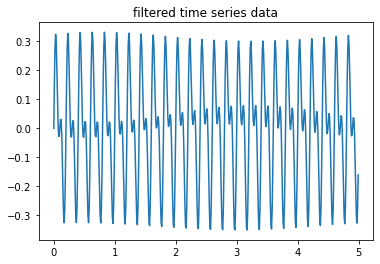

In [28]:
#Use the ifft to recover the Fourier filtered time series
s2=fft.ifft(filtered_fft_fn4)
plt.plot(t,np.real(s2))
plt.title('filtered time series data')
plt.show()

This example illustrates how succesful filtering can be-- but also showcases how clearly filtering can bias the sinal.  For example, it apears there is longwavelenght component to this signal-- this is clearly spurious in this exmaple.

### The art of frequency sampling

We have a chicken and egg problem, on top of a frequency challenge. The signal.fft does not ask anything about the time axis. It therefore requires that the time sampling be uniform. Also, what if the sampling (e.g., of a sine wave) is at or longer than the period. That would likely return a meaningless transorm.

- How do we know what frequency sampling rate to use (i.e., when sampling the time series with an experiment).
- What if we cannot sample the time series data uniformly?

We have been discussing Fourier transforms of continuous signals which are well defined for all times −∞ < t < ∞. Real-world signals only involve some finite span of time, at some finite rate of sampling (often defined by the instrument or experiment). 

The resulting data can be described by a point-wise product of the continuous signal with a
window function. For example, a continuous signal measured over a finite duration is described by a rectangular window function spanning the duration of the observation and a signal measured at regular intervals is described by a Dirac comb window function marking those measurement times.

512


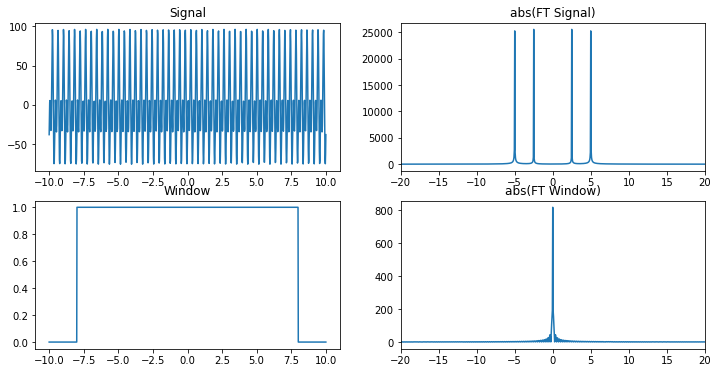

1025 1025


Text(0.5, 1.0, 'abs(Windowed )')

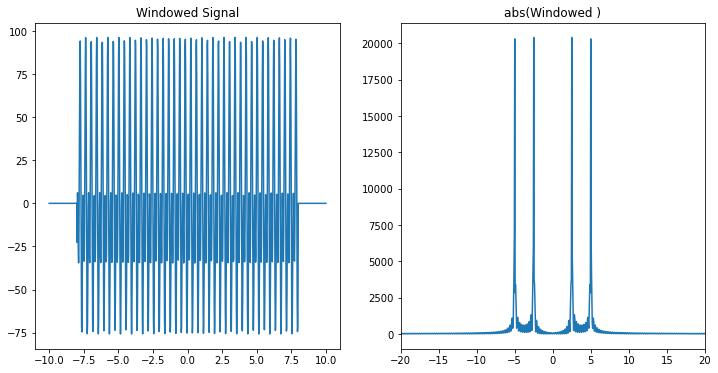

In [86]:
from scipy import signal
#Let's redefine our fn2 and stretch the signal to +/- 4 second:
print(N)
t = np.arange(-N,N+1, dtype=complex)/(N/10)  ## n/N becomes time, a variable from 0 to 1. Note that it is COMPLEX
fn1 = a * np.sin(pi2* k * t + p1 / 360. * pi2)   ## the pure sine wave 
fn2 = a * np.sin(pi2* k * t/2 + p2 / 360. * pi2)   ## the pure sine wave shifted in phase
g_box = np.zeros(len(t))
g_box[where(np.abs(t) < 8)] = 1  ###########. defines the window width  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
########################################################################

dt = t[1]-t[0]
fn12_fft = fft.fft(fn1+fn2)
fn12_freq = fft.fftshift(fft.fftfreq(len(t),dt)) #let fftfreq do the "roll" and shift
fn12_fftshift = fft.fftshift(fn12_fft)

g_fft = fft.fft(g_box)
g_freq = fft.fftshift(fft.fftfreq(len(t),dt)) #let fftfreq do the "roll" and shift
g_fftshift = fft.fftshift(g_fft)


## make plots.
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
ax[0,0].plot(t, fn1+fn2)
ax[0,0].set_title('Signal')
ax[0,1].plot(fn12_freq,np.abs(fn12_fftshift))
ax[0,1].set_xlim(-20,20)
ax[0,1].set_title('abs(FT Signal)')
ax[1,0].plot(t,g_box)
ax[1,0].set_title('Window')
ax[1,1].plot(g_freq,np.abs(g_fftshift))
ax[1,1].set_xlim(-20,20)
ax[1,1].set_title('abs(FT Window)')
plt.show()

tmp = fn1+fn2
#tmp -= np.mean(tmp)
result = np.fft.fftshift(np.fft.fft(tmp*g_box) )
#result =signal.convolve(fn12_fft*np.complex(1),g_fft*np.complex(1), mode='same',method = "direct")
print(size(result),size(g_freq))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(t, tmp*g_box)
ax[0].set_title('Windowed Signal')
ax[1].plot(g_freq,np.abs(result))
ax[1].set_xlim(-20,20)
ax[1].set_title('abs(Windowed )')

In the above figures, we see that the initial signal is detected via the FT where we clearly see 2 delta functions representing the two frequencies of the waves (like magic!).  However, when we window the signal, the convolution has the effect of replacing each delta function with a sinc function in the FT. In other words, the act of windowing spreads out the signal one would detect using the FT.

### Exercise: 
what happens to the detected signal in the observed FT as you widen or narrow the window?  try the range from the full width (periodic infinity) to 0.1. What is the minimum size that allows you to resolve the four singal spikes? discuss.

discuss the results.

What about sampling many times at small $\Delta$t?



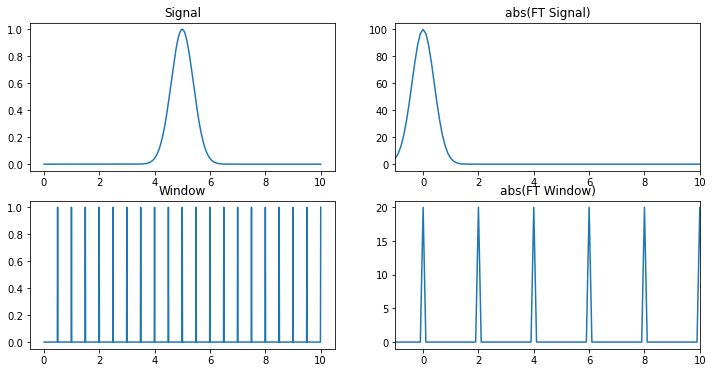

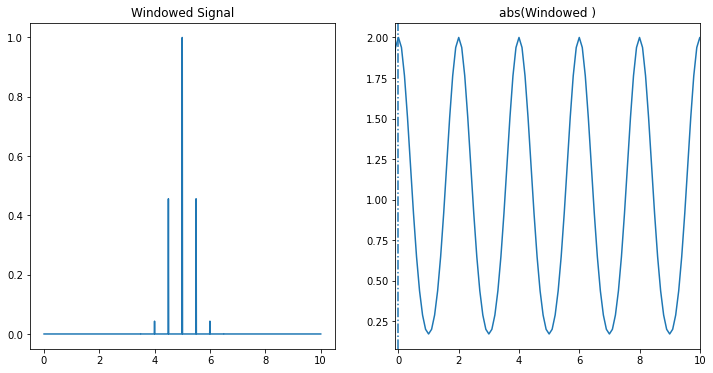

In [100]:
x = np.arange(1,1001,dtype=complex)/100
dx = x[1] - x[0]
freq = fft.fftfreq(len(x),dx) #let fftfreq do the "roll"
mu = 5
fn3 = np.exp(-np.pi*((x-mu)**2))
fn3_fft = fft.fft(fn3)
fn3_freq = fft.fftshift(fft.fftfreq(len(x),dx)) #let fftfreq do the "roll" and shift
fn3_fftshift = fft.fftshift(fn3_fft)


N_comb_samps = 2   ## this is a kludgey way to adjust the number of samples, integers of rational numbers only

g_box = np.zeros(len(x))
x = np.array(x,dtype=float64)
g_comb = [1 if ii.real*N_comb_samps % 1 == 0 else 0 for ii in x]
g_fft = fft.fft(g_comb)
g_freq = fft.fftshift(fft.fftfreq(len(x),dx)) #let fftfreq do the "roll" and shift
g_fftshift = fft.fftshift(g_fft)

#print(g_fftshift)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
ax[0,0].plot(x, fn3)
ax[0,0].set_title('Signal')
ax[0,1].plot(fn3_freq,np.abs(fn3_fftshift))
ax[0,1].set_xlim(-1,10)
ax[0,1].set_title('abs(FT Signal)')
ax[1,0].plot(x,g_comb)
ax[1,0].set_title('Window')
ax[1,1].plot(g_freq,np.abs(g_fftshift))
ax[1,1].set_xlim(-1,10)
ax[1,1].set_title('abs(FT Window)')
plt.show()

#result = signal.convolve(fn3_fft,g_fft, mode='same')  ## should be the same... 

result = np.fft.fftshift(np.fft.fft(fn3*g_comb) )

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(x, (fn3)*g_comb)
ax[0].set_title('Windowed Signal')
ax[1].plot(g_freq,np.abs(result))
ax[1].set_xlim(-0.1,10)
ax[1].set_title('abs(Windowed )')
ax[1].axvline(0,linestyle='-.')

Interestingly, because the Fourier transform of a Dirac comb is another Dirac comb, the effect of such an observing window is to create a long sequence of aliases of the underlying transform with a spacing of 1/T.

The following issues are almost always unavoidable in Fourier analyses of windowed data (and when is data not windowed?):

- the spectrum of the signal that we <i> expected</i> to see turns into a lot of separate (periodic) peaks in the FT of the convolved window and signal.
- the spectrum of the observed (windowed) series is wider as the filter gets narrower.

### Excercise 
How do we deal with these? Play with the window in such a way that you windowed signal is not corrupted (chicken and egg). Examine the ifft of the recovered undelying signal after the FFT analysis and try to make physical sense of what you are seeing. You can rule out peaks that do not fit your physical model.

## Power Spectral Density

In signal processing, we normally use the term "power spectra density" (PSD) as the absolute value of the FT.

In the simple example we have been using of a sine wave with a single frequency, we can plot the "power" by simply taking the absolute value of the Fourier transform of fn1:

Text(0, 0.5, 'PSD')

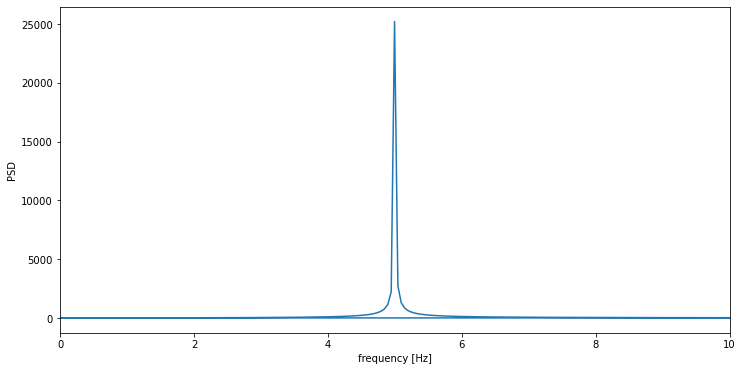

In [102]:
N = 512*1 # degrees (Number of samples)
a = 50 #float(np.random.randint(1, 100))  ## random integer (amplitude) between 0 and 100
k = 5. #float(np.random.randint(1, 50))  ## random integer (frequency) between 0 and 50
p1 = 12 #float(np.random.randint(0, 360))  ## random integer (phase) between 0 and 360
p2 = 256 #float(np.random.randint(0, 360))  ## random integer (phase) between 0 and 360t = np.arange(-N,N, dtype=complex)/(N/10)  ## n/N becomes time, a variable from 0 to 1. Note that it is COMPLEX
fn1 = a * np.sin(2*np.pi* k * t + p1 / 360. * 2*np.pi)   ## the pure sine wave 
dt = t[1] - t[0]
fn1_fft = fft.fft(fn1)
fn1_fftshift = fft.fftshift(fn1_fft)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax.plot(fft.fftfreq(len(t),dt), np.abs(fn1_fft)) #Note that I am NOT rolling/shifting the frequency for PSD. 
ax.set_xlim(0,10)
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD')

Not so interesting, and yes, it looks like the FTT. So why do we care about power?

Recall from above that the (auto)covariance is the numerator of the (auto)correlation. The (auto)correlation is the (auto)covariance divided by the variance.

Suppose that $\gamma(h)$ is the autocovariance function of a stationary process and that $f(\omega)$ is the spectral density for the same process. In the notation of the previous sentence, $h$ = time lag and $\omega$ = frequency.

Mixing together our previous terminologies:

$$E(x_t\ x_{h-t}) = \gamma(h)
$$

We define the <i> spectrum </i> of $x$ (at some or many frequencies) as the (inverse) Fourier transform of $\gamma(h)$:

$$
S(\omega) = \displaystyle\sum_{h=-\infty}^{\infty} e^{-i\omega h} \gamma(h) \tag{24}
$$

We define the power spectrum to be the Fourier transform of the  autocovariance. This provides a physically meaningful intepretation of the power: when the power at some frequency is large, the variance (about the mean) in the time series from that frequency is large and that frequency contributes significantly to the time series. When the power is small, the variance about the mean is small and that frequency does not contribute as much.

At $\omega = 0$, we see that:

$$
\displaystyle\sum_{h=-\infty}^{\infty} \gamma(h) = S(0)
$$
or that the sum of the autocovariance is just equal to the power at frequency zero.

If one uses Euler's relation, you can rewrite the power as

$$
S(\omega) =\gamma(0) + \displaystyle\sum_{h=1}^{\infty} cos(\omega h) \gamma(h)
$$

and by symmetry in cosine and $\gamma(h)$, you find that for spectral analysis, we only need
to find the spectrum for $\omega =-\pi \le \pi$. 

The covariance and spectral density are Fourier transform pairs. This means that just like we could look at zero frequency (e.g. in equation 24), we can also look at zero lag (which is the variance):

$$\gamma(0) = \displaystyle\sum_{\omega = -\pi}^{\pi} S(\omega)$$

This means that the the variance of the time series is the sum of the power. The “total” integrated spectrum equals the variance of the time series. 

Note on limits: $h$ (which here is the lag, in time), goes to infinity. It might start at -infinity or zero, depending on how you express the transform, deal with roll, etc. The <i> spectrum </i> goes from $-\pi$ to $<\pi$ due to the symmetry mentioned above. In terms of power, you only care about zero to $\pi$.

###  Spectrum versus spectral density

In the above, we started with the covariance of the time series. If we normalize this properly, we will have the autocorrelation function as opposed to the covariance function:

$$
f(\omega) = \displaystyle\sum_{h=-\infty}^{\infty} e^{-i\omega h} \rho(h)
$$
where $\rho$ is the autocorrelation of the time series. This has a nice property, which is that at lag $h=0$, we know the value of the correlation: it has to be one:

$$1 =  \displaystyle\sum_{h=-\infty}^{\infty} \rho(h) $$

or 

$$1 =  \displaystyle\int_{\omega=-\pi}^{\pi} f(\omega) d\omega$$

In this sense, $f(\omega)$ is normalized to one (like a probablility), so it is termed the power spectral density.

As mentioned above, it is all about terminology (and normalization).



(0.01953125+0j)


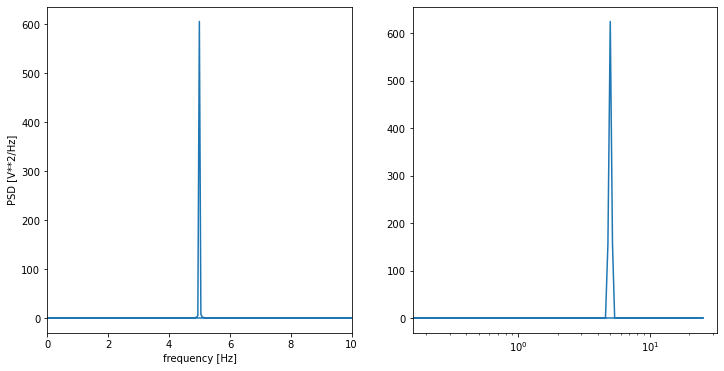

In [32]:
from scipy import signal

N = 512
t = np.arange(-N,N+1, dtype=complex)/(N/10)  ## n/N becomes time, a variable from 0 to 1. Note that it is COMPLEX
fn1 = a * np.sin(pi2* k * t + p1 / 360. * pi2)   ## the pure sine wave 
dt = t[1] - t[0]
print(dt)
f, Pxx_den = signal.periodogram(fn1,scaling='spectrum') #
#In the above case I ingore the sampling frequency, and use fftfreq
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(fft.fftfreq(len(t),dt), Pxx_den)
ax[0].set_xlim(0,10)
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('PSD [V**2/Hz]')
freqs, psd = signal.welch(fn1,1/dt,scaling='spectrum') #This call asks for the sampling frequency (1/dt) and 
#gives back meaninging frequencies
plt.semilogx(freqs, psd)

#ax[1].set_xlim(-10,10)
#ax[1].set_ylim(-50,30)

In [33]:
import sys
!{sys.executable} -m pip install --user lightkurve

       time             flux      ...   pos_corr1      pos_corr2   
                    electron / s  ...      pix            pix      
------------------ -------------- ... -------------- --------------
131.51178135778173  7.3603977e+04 ...  1.0303581e-03 -1.9799426e-02
131.53221582827246  7.3619930e+04 ...  9.5298892e-04 -1.9902917e-02
 131.5526501987697  7.3624562e+04 ...  1.0843917e-03 -2.0035187e-02
 131.5730844693171  7.3640406e+04 ...  1.3153800e-03 -1.9962542e-02
131.59351883981435  7.3624023e+04 ...  5.8365392e-04 -2.0055704e-02
131.61395331031235  7.3623336e+04 ...  6.6329073e-04 -1.9884914e-02
               ...            ... ...            ...            ...
  164.860603231813  7.3637133e+04 ... -3.6063637e-03  3.4708377e-02
164.88103748700087  7.3616047e+04 ... -3.4703508e-03  3.4542605e-02
164.90147164218797  7.3627820e+04 ... -3.4455175e-03  3.4755744e-02
 164.9219058969029  7.3621344e+04 ... -2.8916404e-03  3.4657471e-02
164.94234025162586  7.3614602e+04 ... -3.3365495

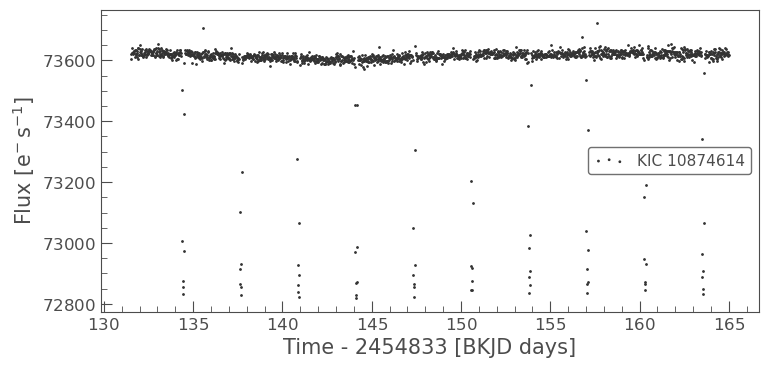

In [34]:
import lightkurve as lk
light_curve = lk.search_lightcurve("Kepler-6", quarter=1).download()
light_curve.scatter()
print(light_curve)
time = light_curve['time']
flux = light_curve['flux']

Uh oh, these data are <b> not </b> sampled on an even frequency! Use the Lomb-Scargle or Boxed Least Squares PSD estimators for the PSD. These are tools designed for uneven sampling.

The Lomb–Scargle periodogram is perhaps the best-known technique to compute periodicity of unequally spaced data in astronomy. We do not have time to go into details, but it is similar to using a least squares technique to statistically infer the PSD. Feel free to peruse [this page](https://exoplanetarchive.ipac.caltech.edu/docs/pgram/pgram_algo.html).

The periodogram is an estimator of the spectral density, the Fourier transform of the autocovariance function.

In [35]:
import matplotlib   # plotting libraries  
import matplotlib.pyplot as plt   # plotting libraries  
import cmath as cm  # complex math
import numpy as np  # numerical routines 
%matplotlib inline  
#Whenever we take the absolute value of the FFT, we will get warnings about losing the imaginary part. Sooo
import warnings
warnings.filterwarnings('ignore')
from scipy import *
from scipy import signal



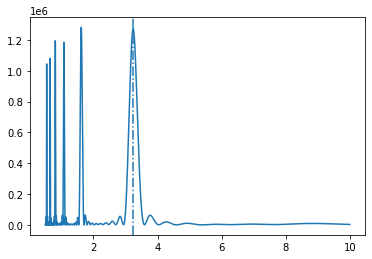

In [36]:

nonnan = ~np.isnan(flux.value)
keep = np.where(nonnan == True)[0]
flux1 = np.array(flux[keep])
time1 = np.array(time.value[keep])
time1 = np.asarray(time1, dtype=np.float64)
#print(flux1.value, time1)
periods=np.arange(0.5, 10, 0.0001)
result = signal.lombscargle(time1,flux1-np.mean(flux1),2*pi/periods)#Note requires data to be centered on mean!
plt.plot(periods,result)
plt.axvline(3.23,linestyle='-.')
#plt.xlim(0,1)
plt.show()

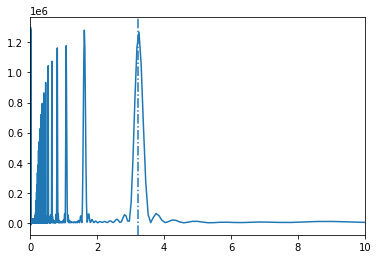

In [37]:
from astropy.timeseries import LombScargle
frequency, power = LombScargle(time1, flux1,normalization='psd').autopower()
plt.plot(1/frequency,power)
plt.xlim(0,10)
plt.axvline(3.23,linestyle='-.')

Let's take the one at 3.23 as the planet. What are those other frequencies?

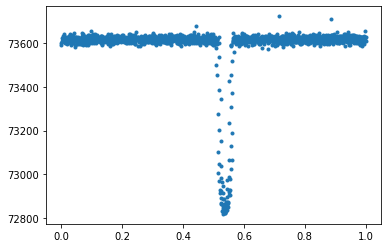

In [105]:
k6b_period = 3.23
T0 = time1[0]+1.2#the offset is TBD

phase = (time1 - T0)/k6b_period - np.floor((time1-T0)/k6b_period)

plt.plot(phase,flux1,'.')

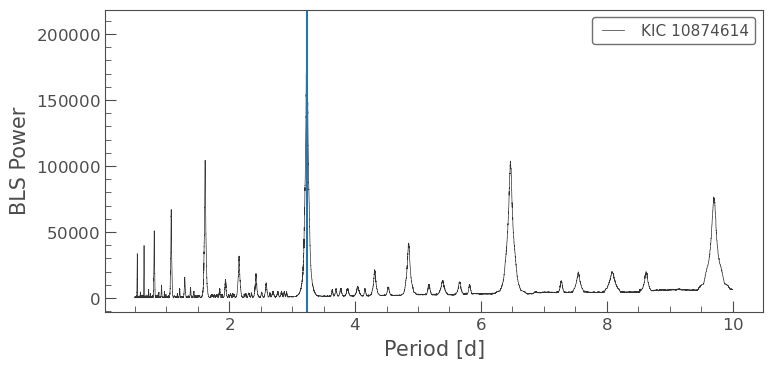

In [39]:
periodogram = light_curve.to_periodogram(method="bls", period=np.arange(0.5, 10, 0.0001))
periodogram.plot()
plt.axvline(3.23)

Real data is messy. Often, the data (or the spectrum) is smoothed, "pre-whitened+, filtered, and otherwise manipulated in order to make sense in a Fourier-like analysis.

"It is extremely difficult to derive the significance of a weak periodicity from harmonic analysis. Do not believe analytical estimates (e.g. exponential probability), as they rarely apply to real data. It is essential to make simulations, typically permuting or bootstrapping the data keeping the observing times fixed. Simulations of the final model with the observation times is also advised." -- Eric Feigelson.